In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib import style
from scipy.fftpack import fft, rfft
# import pickle
from sklearn.cluster import KMeans, DBSCAN
from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import NearestNeighbors
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn import metrics
# from sklearn.preprocessing import StandardScaler
# from sklearn.metrics import accuracy_score

In [2]:
style.use('ggplot')
#load Insulin and CGM Data
insulin_df = pd.read_csv('InsulinData.csv', parse_dates=[['Date','Time']],low_memory=False).iloc[::-1]
cgm_df = pd.read_csv('CGMData.csv', parse_dates=[['Date','Time']],low_memory=False).iloc[::-1]

cgm_df

,Date_Time,Index,New Device Time,BG Reading (mg/dL),Linked BG Meter ID,Basal Rate (U/h),Temp Basal Amount,Temp Basal Type,Temp Basal Duration (h:mm:ss),Bolus Type,...,Scroll Step Size,Insulin Action Curve Time,Sensor Calibration Rejected Reason,Preset Bolus,Bolus Source,Network Device Associated Reason,Network Device Disassociated Reason,Network Device Disconnected Reason,Sensor Exception,Preset Temp Basal Name
55342,2017-07-25 12:08:54,52859,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
55341,2017-07-25 12:13:54,52858,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
55340,2017-07-25 12:18:54,52857,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
55339,2017-07-25 12:23:54,52856,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
55338,2017-07-25 12:28:54,52855,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4,2018-02-12 13:02:27,20359,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SENSOR_ERROR,NaN
3,2018-02-12 13:07:27,20358,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SENSOR_ERROR,NaN
2,2018-02-12 13:12:27,20357,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SENSOR_ERROR,NaN
1,2018-02-12 13:17:27,20356,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
insulin_df = insulin_df[['Date_Time','BWZ Carb Input (grams)']]
insulin_Meal_df= insulin_df[insulin_df['BWZ Carb Input (grams)'].notnull() & insulin_df['BWZ Carb Input (grams)'] != 0]
insulin_Meal_df

,Date_Time,BWZ Carb Input (grams)
41401,2017-07-25 10:21:19,91.0
41393,2017-07-25 10:39:46,58.0
41347,2017-07-25 18:31:40,115.0
41274,2017-07-26 09:27:16,72.0
41265,2017-07-26 11:24:52,20.0
...,...,...
222,2018-02-11 16:27:04,40.0
207,2018-02-11 18:14:37,8.0
188,2018-02-11 20:33:18,71.0
129,2018-02-12 02:30:55,15.0


In [4]:
insulin_Meal_df.loc[:, 'Time_dif1'] = insulin_Meal_df['Date_Time'].diff(periods=-1)/np.timedelta64(1,'h')
insulin_Meal_df.loc[:,'Time_dif2'] = insulin_Meal_df['Date_Time'].diff(periods=1)/np.timedelta64(1,'h')
insulin_Meal_df

C:\Users\wayne\anaconda3\envs\py36_cse572\lib\site-packages\pandas\core\indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\wayne\anaconda3\envs\py36_cse572\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,Date_Time,BWZ Carb Input (grams),Time_dif1,Time_dif2
41401,2017-07-25 10:21:19,91.0,-0.307500,NaN
41393,2017-07-25 10:39:46,58.0,-7.865000,0.307500
41347,2017-07-25 18:31:40,115.0,-14.926667,7.865000
41274,2017-07-26 09:27:16,72.0,-1.960000,14.926667
41265,2017-07-26 11:24:52,20.0,-1.396944,1.960000
...,...,...,...,...
222,2018-02-11 16:27:04,40.0,-1.792500,0.877222
207,2018-02-11 18:14:37,8.0,-2.311389,1.792500
188,2018-02-11 20:33:18,71.0,-5.960278,2.311389
129,2018-02-12 02:30:55,15.0,-6.747222,5.960278


In [5]:
filt=((insulin_Meal_df['Time_dif1']<-2) | (insulin_Meal_df['Time_dif2'].iloc[-1:]>2))
insulin_Meal_df = insulin_Meal_df.loc[filt]
# insulin_Meal_df

In [6]:
binSize = 20
MaxVals = insulin_Meal_df['BWZ Carb Input (grams)'].max()
MinVals = insulin_Meal_df['BWZ Carb Input (grams)'].min()
print(MaxVals, MinVals)

129.0 3.0


In [7]:
nBins = math.floor((MaxVals-MinVals)/20)
# nBins = math.ceil((MaxVals-MinVals)/20)
nBins

6

In [8]:
insulin_Meal_df['Ground Truth Label'] = ((insulin_Meal_df['BWZ Carb Input (grams)']-MinVals)/20).apply(np.floor)
# insulin_Meal_df['Ground Truth Label'] = ((insulin_Meal_df['BWZ Carb Input (grams)']-MinVals)/20).apply(np.ceil)
insulin_Meal_df

C:\Users\wayne\anaconda3\envs\py36_cse572\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Date_Time,BWZ Carb Input (grams),Time_dif1,Time_dif2,Ground Truth Label
41393,2017-07-25 10:39:46,58.0,-7.865000,0.307500,2.0
41347,2017-07-25 18:31:40,115.0,-14.926667,7.865000,5.0
41261,2017-07-26 12:48:41,63.0,-6.440278,1.396944,3.0
41214,2017-07-26 19:15:06,60.0,-10.512500,6.440278,2.0
41172,2017-07-27 05:45:51,24.0,-3.563889,10.512500,1.0
...,...,...,...,...,...
261,2018-02-11 12:43:23,27.0,-2.850833,2.684444,1.0
207,2018-02-11 18:14:37,8.0,-2.311389,1.792500,0.0
188,2018-02-11 20:33:18,71.0,-5.960278,2.311389,3.0
129,2018-02-12 02:30:55,15.0,-6.747222,5.960278,0.0


In [9]:
x = insulin_Meal_df.loc[insulin_Meal_df['Date_Time']=='2017-07-25 10:39:46']['Ground Truth Label'].iloc[0]
print(x)

2.0


In [10]:
#CGM meal datetime
CGM_Meal_Date_Time = []

for datetime in insulin_Meal_df['Date_Time']:
    l = []
    CGM_Meal_Datetime = cgm_df.loc[cgm_df['Date_Time']>=datetime]['Date_Time'].min()
    if CGM_Meal_Datetime >= cgm_df['Date_Time'].min() + pd.to_timedelta(30, unit='m') and CGM_Meal_Datetime <= cgm_df['Date_Time'].max() - pd.to_timedelta(120, unit='m'):
#         CGM_Meal_Date_Time.append(CGM_Meal_Datetime)
        l.append(CGM_Meal_Datetime)
        l.append(insulin_Meal_df.loc[insulin_Meal_df['Date_Time']==datetime]['Ground Truth Label'].iloc[0])
        l.append(insulin_Meal_df.loc[insulin_Meal_df['Date_Time']==datetime]['BWZ Carb Input (grams)'].iloc[0])
        CGM_Meal_Date_Time.append(l)
CGM_Meal_Date_Time

[[Timestamp('2017-07-25 18:33:55'), 5.0, 115.0],
 [Timestamp('2017-07-26 12:49:00'), 3.0, 63.0],
 [Timestamp('2017-07-26 19:19:01'), 2.0, 60.0],
 [Timestamp('2017-07-27 05:49:05'), 1.0, 24.0],
 [Timestamp('2017-07-27 09:24:05'), 2.0, 47.0],
 [Timestamp('2017-07-27 13:59:06'), 2.0, 54.0],
 [Timestamp('2017-07-27 18:59:08'), 3.0, 73.0],
 [Timestamp('2017-07-28 08:54:11'), 3.0, 70.0],
 [Timestamp('2017-07-28 15:19:12'), 2.0, 55.0],
 [Timestamp('2017-07-28 21:39:14'), 2.0, 60.0],
 [Timestamp('2017-07-29 18:09:19'), 5.0, 112.0],
 [Timestamp('2017-07-29 21:34:19'), 1.0, 24.0],
 [Timestamp('2017-07-30 18:29:26'), 3.0, 80.0],
 [Timestamp('2017-07-31 05:49:29'), 1.0, 24.0],
 [Timestamp('2017-07-31 09:54:29'), 2.0, 51.0],
 [Timestamp('2017-07-31 13:02:12'), 0.0, 15.0],
 [Timestamp('2017-07-31 15:07:12'), 5.0, 122.0],
 [Timestamp('2017-07-31 18:12:12'), 0.0, 19.0],
 [Timestamp('2017-08-01 05:52:15'), 1.0, 24.0],
 [Timestamp('2017-08-01 09:52:17'), 2.0, 45.0],
 [Timestamp('2017-08-01 13:47:17'), 4

In [11]:
CGM_Meal_Date_Time

[[Timestamp('2017-07-25 18:33:55'), 5.0, 115.0],
 [Timestamp('2017-07-26 12:49:00'), 3.0, 63.0],
 [Timestamp('2017-07-26 19:19:01'), 2.0, 60.0],
 [Timestamp('2017-07-27 05:49:05'), 1.0, 24.0],
 [Timestamp('2017-07-27 09:24:05'), 2.0, 47.0],
 [Timestamp('2017-07-27 13:59:06'), 2.0, 54.0],
 [Timestamp('2017-07-27 18:59:08'), 3.0, 73.0],
 [Timestamp('2017-07-28 08:54:11'), 3.0, 70.0],
 [Timestamp('2017-07-28 15:19:12'), 2.0, 55.0],
 [Timestamp('2017-07-28 21:39:14'), 2.0, 60.0],
 [Timestamp('2017-07-29 18:09:19'), 5.0, 112.0],
 [Timestamp('2017-07-29 21:34:19'), 1.0, 24.0],
 [Timestamp('2017-07-30 18:29:26'), 3.0, 80.0],
 [Timestamp('2017-07-31 05:49:29'), 1.0, 24.0],
 [Timestamp('2017-07-31 09:54:29'), 2.0, 51.0],
 [Timestamp('2017-07-31 13:02:12'), 0.0, 15.0],
 [Timestamp('2017-07-31 15:07:12'), 5.0, 122.0],
 [Timestamp('2017-07-31 18:12:12'), 0.0, 19.0],
 [Timestamp('2017-08-01 05:52:15'), 1.0, 24.0],
 [Timestamp('2017-08-01 09:52:17'), 2.0, 45.0],
 [Timestamp('2017-08-01 13:47:17'), 4

In [12]:
mealDataMatrix = []
for mealDateTime in CGM_Meal_Date_Time:
#     print(mealDateTime)
#     idx = cgm_df[cgm_df['Date_Time'] == mealDateTime]['Sensor Glucose (mg/dL)'].index[0]
    idx = cgm_df[cgm_df['Date_Time'] == mealDateTime[0]]['Sensor Glucose (mg/dL)'].index[0]
    l = list(cgm_df['Sensor Glucose (mg/dL)'].iloc[cgm_df.shape[0]-1-idx-6:cgm_df.shape[0]-1-idx+24].values)
    l.append(mealDateTime[1])
    l.append(mealDateTime[2])
    mealDataMatrix.append(l)
#     mealDataMatrix.append(list(cgm_df['Sensor Glucose (mg/dL)'].iloc[cgm_df.shape[0]-1-idx-6:cgm_df.shape[0]-1-idx+24].values))
mealDataMatrix

[[58.0,
  59.0,
  63.0,
  71.0,
  81.0,
  102.0,
  131.0,
  140.0,
  147.0,
  153.0,
  159.0,
  163.0,
  159.0,
  153.0,
  151.0,
  155.0,
  163.0,
  164.0,
  nan,
  166.0,
  168.0,
  164.0,
  169.0,
  178.0,
  184.0,
  190.0,
  195.0,
  198.0,
  203.0,
  196.0,
  5.0,
  115.0],
 [304.0,
  292.0,
  281.0,
  268.0,
  259.0,
  255.0,
  248.0,
  241.0,
  231.0,
  220.0,
  222.0,
  222.0,
  222.0,
  223.0,
  224.0,
  228.0,
  233.0,
  243.0,
  256.0,
  262.0,
  270.0,
  277.0,
  274.0,
  269.0,
  267.0,
  267.0,
  274.0,
  284.0,
  283.0,
  278.0,
  3.0,
  63.0],
 [40.0,
  40.0,
  40.0,
  40.0,
  60.0,
  71.0,
  83.0,
  87.0,
  100.0,
  112.0,
  121.0,
  125.0,
  130.0,
  132.0,
  123.0,
  112.0,
  89.0,
  77.0,
  69.0,
  66.0,
  67.0,
  71.0,
  75.0,
  74.0,
  72.0,
  70.0,
  67.0,
  74.0,
  77.0,
  81.0,
  2.0,
  60.0],
 [212.0,
  210.0,
  204.0,
  200.0,
  199.0,
  201.0,
  201.0,
  194.0,
  188.0,
  183.0,
  181.0,
  176.0,
  170.0,
  168.0,
  169.0,
  172.0,
  179.0,
  192.0,
  203.0,

In [13]:
# mealDate_dict = {}
# for datetime, g_value in zip(CGM_Meal_Date_Time,mealDataMatrix):
#     mealDate_dict[datetime] = g_value
# print(mealDate_dict)

In [14]:
# mealDataMatrix_df = pd.DataFrame.from_dict(mealDate_dict, orient='index')
# mealDataMatrix_df = mealDataMatrix_df.dropna()
# mealDataMatrix_df
meal_df = pd.DataFrame(mealDataMatrix)

meal_df.rename(columns ={30:'Class Label'}, inplace=True)
meal_df = meal_df.dropna()
meal_df


,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,Class Label,31
1,304.0,292.0,281.0,268.0,259.0,255.0,248.0,241.0,231.0,220.0,...,274.0,269.0,267.0,267.0,274.0,284.0,283.0,278.0,3.0,63.0
2,40.0,40.0,40.0,40.0,60.0,71.0,83.0,87.0,100.0,112.0,...,75.0,74.0,72.0,70.0,67.0,74.0,77.0,81.0,2.0,60.0
3,212.0,210.0,204.0,200.0,199.0,201.0,201.0,194.0,188.0,183.0,...,212.0,216.0,213.0,210.0,210.0,209.0,210.0,209.0,1.0,24.0
4,145.0,141.0,137.0,133.0,129.0,124.0,125.0,122.0,123.0,130.0,...,189.0,183.0,179.0,177.0,173.0,165.0,153.0,152.0,2.0,47.0
5,40.0,40.0,46.0,53.0,57.0,57.0,55.0,58.0,70.0,77.0,...,147.0,157.0,172.0,175.0,183.0,191.0,198.0,200.0,2.0,54.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
596,61.0,59.0,59.0,60.0,65.0,70.0,82.0,100.0,126.0,133.0,...,158.0,162.0,169.0,163.0,155.0,136.0,114.0,106.0,1.0,40.0
597,57.0,58.0,62.0,74.0,104.0,110.0,126.0,133.0,135.0,141.0,...,207.0,209.0,206.0,197.0,185.0,191.0,197.0,202.0,0.0,10.0
598,209.0,219.0,221.0,221.0,216.0,217.0,215.0,211.0,201.0,200.0,...,180.0,190.0,196.0,203.0,206.0,212.0,215.0,208.0,1.0,27.0
600,106.0,107.0,100.0,104.0,123.0,132.0,129.0,127.0,120.0,132.0,...,173.0,166.0,162.0,189.0,201.0,200.0,194.0,177.0,3.0,71.0


In [15]:
meal_df['Class Label'].describe()

count    462.000000
mean       1.385281
std        1.212212
min        0.000000
25%        0.000000
50%        1.000000
75%        2.000000
max        5.000000
Name: Class Label, dtype: float64

In [16]:
# p = np.array(meal_df['Class Label'])
# p = p.reshape(-1,1)
# print(p)
# print(meal_df['Class Label'].value_counts())
# meal_df['Class Label'].value_counts().plot()
# p = np.array(meal_df['Class Label'].value_counts())
# print(p)
# y =[1,0,2,3,4,5]
# meal_df['Class Label'].value_counts()
             
# plt.scatter(p,y)

In [17]:
# meal_df['Mean_CGM'].plot()

In [18]:
FFT_Min, FFT_Max, FFT_Varr = [], [], []
rff = rfft(meal_df.iloc[:,0:29])
for i in range(len(rff)):
    m = min(rff[i])
    ma = max(rff[i])
    variance = np.var(rff[i])
    FFT_Min.append(m)
    FFT_Max.append(ma)
    FFT_Varr.append(variance)


meal_df["FFTMAX"] = FFT_Max
meal_df["FFTMIN"] = FFT_Min
meal_df["FFTVAR"] = FFT_Varr


<AxesSubplot:>

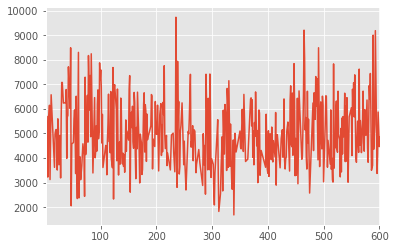

In [19]:
meal_df["FFTMAX"].plot()

In [20]:
meal_df["FFTMIN"]

1     -109.137202
2     -415.302527
3      -98.034977
4     -343.841414
5     -120.527900
          ...    
596   -289.490876
597   -317.557578
598   -156.644731
600   -177.907857
602   -105.795958
Name: FFTMIN, Length: 462, dtype: float64

<AxesSubplot:>

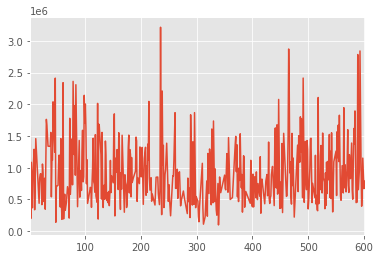

In [21]:
meal_df["FFTVAR"].plot()

In [22]:
meal_df['Min_ind'] = meal_df.iloc[:,0:29].idxmin(axis=1)
meal_df['Min_ind']

1       9
2       0
3      13
4       7
5       0
       ..
596     1
597     0
598    19
600     2
602     1
Name: Min_ind, Length: 462, dtype: int64

In [23]:
meal_df['Max_ind'] = meal_df.iloc[:,0:29].idxmax(axis=1)
meal_df['Max_ind']

1       0
2      13
3      23
4      18
5      28
       ..
596    24
597    23
598     2
600    26
602    22
Name: Max_ind, Length: 462, dtype: int64

In [24]:
meal_df['Max_Min_inddiff'] = meal_df['Max_ind'] - meal_df['Min_ind']
meal_df['Max_Min_inddiff'].abs()

1       9
2      13
3      10
4      11
5      28
       ..
596    23
597    23
598    17
600    24
602    21
Name: Max_Min_inddiff, Length: 462, dtype: int64

In [25]:
meal_df['Max_CGM'] = meal_df.iloc[:,0:29].max(axis=1)
meal_df['Min_CGM'] = meal_df.iloc[:,0:29].min(axis=1)
meal_df['Mean_CGM'] = meal_df.iloc[:,0:29].mean(axis=1)
meal_df['Max_Min_PCT'] = (meal_df['Max_CGM'] - meal_df['Min_CGM'])/meal_df['Min_CGM']*100
meal_df['Max_Min_Slope'] = (meal_df['Max_CGM'] - meal_df['Min_CGM'])/meal_df['Max_Min_inddiff'].abs()
meal_df['Feature1'] =(((meal_df['Max_CGM']-meal_df['Mean_CGM'])*(meal_df['Min_CGM']-meal_df['Mean_CGM']))**2)/meal_df['Min_CGM']
meal_df['Feature2'] = (2*meal_df['Max_CGM']*meal_df['Min_CGM'])/(meal_df['Max_CGM']+meal_df['Min_CGM'])
meal_df['Feature3'] = meal_df.iloc[:,31]
meal_df

,0,1,2,3,4,5,6,7,8,9,...,Max_ind,Max_Min_inddiff,Max_CGM,Min_CGM,Mean_CGM,Max_Min_PCT,Max_Min_Slope,Feature1,Feature2,Feature3
1,304.0,292.0,281.0,268.0,259.0,255.0,248.0,241.0,231.0,220.0,...,0,-9,304.0,220.0,255.137931,38.181818,9.333333,13399.031129,255.267176,63.0
2,40.0,40.0,40.0,40.0,60.0,71.0,83.0,87.0,100.0,112.0,...,13,13,132.0,40.0,81.517241,230.000000,7.076923,109820.431142,61.395349,60.0
3,212.0,210.0,204.0,200.0,199.0,201.0,201.0,194.0,188.0,183.0,...,23,10,216.0,168.0,196.896552,28.571429,4.800000,1813.870566,189.000000,24.0
4,145.0,141.0,137.0,133.0,129.0,124.0,125.0,122.0,123.0,130.0,...,18,11,213.0,122.0,166.137931,74.590164,8.272727,35067.679646,155.140299,47.0
5,40.0,40.0,46.0,53.0,57.0,57.0,55.0,58.0,70.0,77.0,...,28,28,198.0,40.0,111.206897,395.000000,5.642857,954892.671231,66.554622,54.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
596,61.0,59.0,59.0,60.0,65.0,70.0,82.0,100.0,126.0,133.0,...,24,23,169.0,59.0,116.344828,186.440678,4.782609,154532.051205,87.464912,40.0
597,57.0,58.0,62.0,74.0,104.0,110.0,126.0,133.0,135.0,141.0,...,23,23,209.0,57.0,143.586207,266.666667,6.608696,562809.267244,89.571429,10.0
598,209.0,219.0,221.0,221.0,216.0,217.0,215.0,211.0,201.0,200.0,...,2,-17,221.0,177.0,202.517241,24.858757,2.588235,1256.688847,196.567839,27.0
600,106.0,107.0,100.0,104.0,123.0,132.0,129.0,127.0,120.0,132.0,...,26,24,201.0,100.0,153.965517,101.000000,4.208333,64426.632634,133.554817,71.0


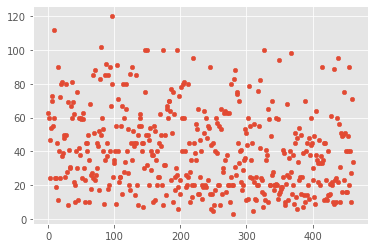

In [26]:
n = np.arange(0,462)
plt.scatter(n,meal_df.iloc[:,31],s=20)
# plt.scatter(n,meal_df['Feature2'],alpha=0.5)

In [27]:
# meal_df = meal_df[['Mean_CGM','Feature1','Feature2','Max_Min_PCT','Max_Min_Slope','FFTVAR','Class Label']]
# meal_df = meal_df[['Feature1','Feature2','Max_Min_PCT','Max_Min_Slope','FFTVAR','Class Label']]
# meal_df = meal_df[['Feature1','Feature2','Max_Min_PCT','Max_Min_Slope','Class Label']]
# meal_df = meal_df[['Feature2','Max_Min_Slope','Class Label']]
# meal_df = meal_df[['Feature3','Feature2','Class Label']]
# meal_df = meal_df[['Feature3','Max_CGM','Class Label']]
meal_df = meal_df[['Feature3','Feature1','Class Label']]
# meal_df = meal_df[['Feature3','Class Label']]
# meal_df = meal_df[['Feature1','Max_Min_Slope','FFTVAR','Class Label']]
# meal_df = meal_df[['Feature1','Max_CGM','Min_CGM','Class Label']]

meal_df

,Feature3,Feature1,Class Label
1,63.0,13399.031129,3.0
2,60.0,109820.431142,2.0
3,24.0,1813.870566,1.0
4,47.0,35067.679646,2.0
5,54.0,954892.671231,2.0
...,...,...,...
596,40.0,154532.051205,1.0
597,10.0,562809.267244,0.0
598,27.0,1256.688847,1.0
600,71.0,64426.632634,3.0


In [28]:
# data = meal_df[['Max_Min_Slope','Class Label']]

In [29]:
meal_df['Class Label'].value_counts()

1.0    135
0.0    133
2.0    109
3.0     55
4.0     28
5.0      2
Name: Class Label, dtype: int64

In [30]:
# data.shape

In [31]:
X = np.array(meal_df.drop(['Class Label'],1))
X = preprocessing.scale(X)
# X = X.reshape(-1,1)
# X_normalized = MinMaxScaler().fit(X).transform(X)
y = np.array(meal_df['Class Label'])
print(X)

[[ 9.40808948e-01 -2.59846415e-01]
 [ 8.15452170e-01 -1.74029476e-01]
 [-6.88829162e-01 -2.70157435e-01]
 [ 2.72239467e-01 -2.40560892e-01]
 [ 5.64738615e-01  5.78101408e-01]
 [ 1.35866487e+00 -1.82242863e-01]
 [ 1.23330810e+00 -1.78074390e-01]
 [ 6.06524207e-01 -1.36499105e-01]
 [ 8.15452170e-01 -2.15060621e-01]
 [ 2.98830298e+00 -2.64036787e-01]
 [-6.88829162e-01 -2.41763606e-01]
 [-8.97757125e-01 -2.21817814e-01]
 [-6.88829162e-01 -2.61381596e-01]
 [ 1.88668282e-01 -1.44891550e-01]
 [ 2.06901995e+00 -1.33070569e-01]
 [-1.23204187e+00 -2.62563008e-01]
 [-2.02596812e-02 -2.61213221e-01]
 [-6.88829162e-01 -2.31028149e-01]
 [ 1.31687928e+00 -5.70390010e-02]
 [ 1.65116402e+00 -2.58981434e-01]
 [ 1.69294961e+00 -2.58194680e-01]
 [-1.45616459e-01 -1.28655681e-01]
 [-6.20452738e-02 -2.39702941e-01]
 [ 3.97596244e-01  3.10552504e-02]
 [ 3.14025059e-01  2.42436243e+00]
 [-6.47043570e-01 -2.69043433e-01]
 [ 1.65116402e+00  7.98815177e-02]
 [ 3.97596244e-01  1.55723453e-01]
 [-5.21686792e-01 -2

In [32]:
km =KMeans(n_clusters=nBins )
km.fit(X)
y_label_km = km.labels_
km_sse=km.inertia_
# print(y_label_km)
SSE_score_km = mean_squared_error(y, y_label_km)
ldf = pd.DataFrame(y_label_km)
ldf.iloc[:,0].value_counts()

1    183
5    129
0     87
3     51
4     10
2      2
Name: 0, dtype: int64

In [33]:
meal_df['Class Label'].value_counts()

1.0    135
0.0    133
2.0    109
3.0     55
4.0     28
5.0      2
Name: Class Label, dtype: int64

In [34]:
max1 = max2 = 0
for i in range(10):
    km =KMeans(n_clusters=nBins )
    km.fit(X)
    y_label_km = km.labels_
    centroids = km.cluster_centers_
    accuracy_km = metrics.accuracy_score(y, y_label_km)
    km_sse=km.inertia_
    SSE_score_km = mean_squared_error(y, y_label_km)
    if accuracy_km > max1:
        max1 = accuracy_km
        aril = metrics.adjusted_rand_score(y, y_label_km)
        SSE_score_km = mean_squared_error(y, y_label_km)
    
# print(SSE_score_km)

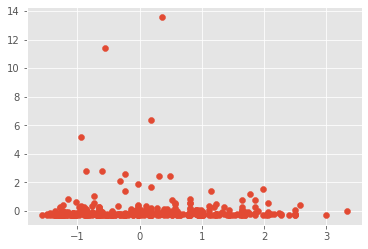

In [35]:
plt.scatter(X[:,0], X[:,1])


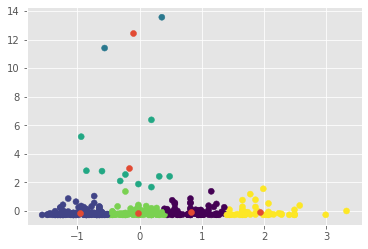

In [36]:
plt.scatter(X[:,0], X[:,1],c=y_label_km)
plt.scatter(centroids[:,0],centroids[:,1])

In [37]:
max1 = max2 = 0

km =KMeans(n_clusters=nBins )
km.fit(X)
y_label_km = km.labels_
centroids = km.cluster_centers_
accuracy_km = metrics.accuracy_score(y, y_label_km)
km_sse=km.inertia_
SSE_score_km = mean_squared_error(y, y_label_km)
# #     print(km_sse,SSE_score_km)
#     if accuracy_km > max1:
#         max1 = accuracy_km
#         aril = metrics.adjusted_rand_score(y, y_label_km)
#         SSE_score_km = mean_squared_error(y, y_label_km)
    
print(accuracy_km)

0.18614718614718614


In [38]:
conv = metrics.cluster.contingency_matrix(y, y_label_km)
print(conv)

[[  0 131   2   0   0   0]
 [  0  50   4   0  80   1]
 [  0   0   4  69  35   1]
 [ 23   0   0  32   0   0]
 [ 28   0   0   0   0   0]
 [  2   0   0   0   0   0]]


In [39]:
conv.shape

(6, 6)

In [40]:
total = len(y)
entropy_km= 0
for x in range(len(conv)):
    local_total = sum(conv[x])
    local_entropy = 0
    for i in range(len(conv[x])):
        if conv[x][i] == 0:
            continue
        local_entropy = local_entropy - ((conv[x][i]/local_total)*math.log((conv[x][i]/local_total), 2))
    entropy_km = entropy_km + (local_entropy*(local_total/total))
print(entropy_km)    

0.7728334562485968


In [41]:
purity_km =  np.sum(np.amax(conv, axis=0)) / np.sum(conv)
print(purity_km)

0.6774891774891775


In [42]:
print("SSE: {}, Entropy: {}, Purity: {}".format(SSE_score_km, entropy_km, purity_km))

SSE: 3.9004329004329006, Entropy: 0.7728334562485968, Purity: 0.6774891774891775


In [43]:
# for i in range(10):
#     cluster = AgglomerativeClustering(n_clusters = nBins, affinity='euclidean', linkage='ward')
#     cluster.fit(X)
#     y_label_db = cluster.labels_
#     h_clusters_df = pd.DataFrame(y_label_db)
#     data = preprocessing.scale(h_clusters_df)
#     db = DBSCAN(eps = 0.05, min_samples = 2).fit(data)
#     y_label_db = db.labels_
#     n_clusters_ = len(set(y_label_db)) - (1 if -1 in y_label_db else 0)
#     accuracy_db = metrics.accuracy_score(y, y_label_db)
#     cluster_score = metrics.adjusted_rand_score(y, y_label_db)
#     if accuracy_db > max2:
#         max2 = accuracy_db
#         SSE_score_db = mean_squared_error(y, y_label_db)
# print(SSE_score_db)

In [44]:
# for i in range(10):
#     cluster = AgglomerativeClustering(n_clusters = nBins, affinity='euclidean', linkage='ward')
# #     cluster = AgglomerativeClustering(n_clusters = nBins, affinity='euclidean')
#     cluster.fit(X)
#     y_label_db = cluster.labels_
#     h_clusters_df = pd.DataFrame(y_label_db)
data = StandardScaler().fit_transform(X)
# print(data)
# db = DBSCAN(eps =0.082, min_samples = 5).fit(X)
db = DBSCAN(eps =0.042, min_samples = 10).fit(X)
y_label_db = db.labels_
# y_pred = DBSCAN(eps=0.2, min_samples=1).fit_predict(X)
n_clusters_ = len(set(y_label_db)) - (1 if -1 in y_label_db else 0)
accuracy_db = metrics.accuracy_score(y, y_label_db)
cluster_score = metrics.adjusted_rand_score(y, y_label_db)
if accuracy_db > max2:
    max2 = accuracy_db
SSE_score_db = mean_squared_error(y, y_label_db)
print(n_clusters_)
conv = metrics.cluster.contingency_matrix(y, y_label_db)
print(conv)

7
[[71  0 26  0  0  0 22 14]
 [92 17  0 15 11  0  0  0]
 [96  0  0  0  0 13  0  0]
 [55  0  0  0  0  0  0  0]
 [28  0  0  0  0  0  0  0]
 [ 2  0  0  0  0  0  0  0]]


(0.0, 1.0)

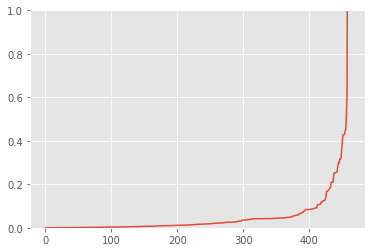

In [45]:
#find optimal eps
neigh = NearestNeighbors(n_neighbors=2)
nbrs =neigh.fit(X)
distance, indices = nbrs.kneighbors(X)
# print(distance, indices)
distances = np.sort(distance, axis=0)
distances = distances[:,1]
plt.plot(distances)
plt.ylim(0,1)

In [46]:
# plt.scatter(X[:,0], X[:,1])

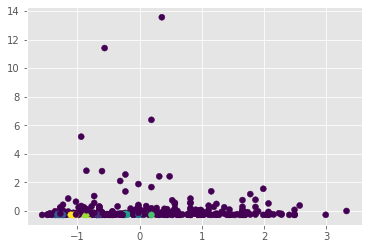

In [47]:
plt.scatter(X[:,0], X[:,1],c=y_label_db)

In [48]:
conv = metrics.cluster.contingency_matrix(y, y_label_db)
total = len(y)
entropy_db= 0
for x in range(len(conv)):
    local_total = sum(conv[x])
    local_entropy = 0
    for i in range(len(conv[x])):
        if conv[x][i] == 0:
            continue
        local_entropy = local_entropy - ((conv[x][i]/local_total)*math.log((conv[x][i]/local_total), 2))
    entropy_db = entropy_db + (local_entropy*(local_total/total))
purity_db =  (np.sum(np.amax(conv, axis=0))) / np.sum(conv)
# print(np.amax(conv, axis=0))
# print(np.sum(np.amax(conv, axis=0)))
# print(metrics.silhouette_score(X,y_label_db))
print("SSE: {}, Entropy: {}, Purity: {}".format(SSE_score_db, entropy_db, purity_db))
# print(" Entropy: {}, Purity: {}".format( entropy_db, purity_db))

SSE: 9.01082251082251, Entropy: 1.0273312269397692, Purity: 0.46320346320346323


In [49]:
np_array = np.array([SSE_score_km, SSE_score_db, entropy_km, entropy_db, purity_km, purity_db])
# np_array.tofile('Result.csv', sep = ',')
print(SSE_score_km, SSE_score_db, entropy_km, entropy_db, purity_km, purity_db)

3.9004329004329006 9.01082251082251 0.7728334562485968 1.0273312269397692 0.6774891774891775 0.46320346320346323
